# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [11]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.vis_utils import plot_model

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [12]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [13]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [14]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          16512       dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           8256        dense_4[0][0]                    
____________________________________________________________________________________________

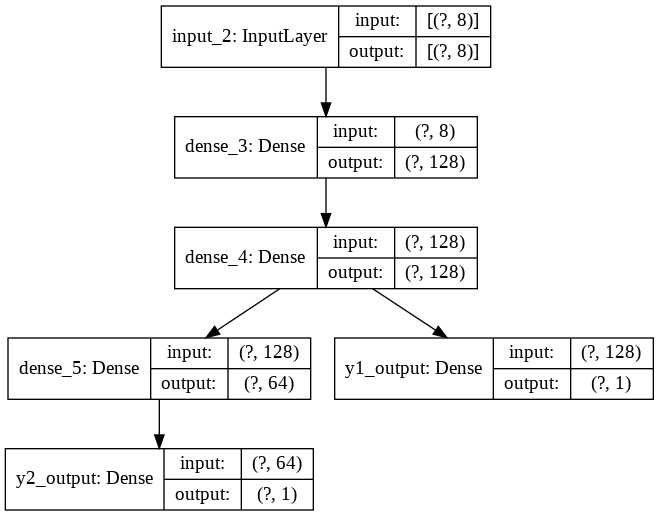

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi-output-model.png')

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [6]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [7]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 1ms/sample - loss: 256.3017 - y1_output_loss: 119.3989 - y2_output_loss: 134.4547 - y1_output_root_mean_squared_error: 10.9795 - y2_output_root_mean_squared_error: 11.6513 - val_loss: 38.7040 - val_y1_output_loss: 17.8165 - val_y2_output_loss: 21.7155 - val_y1_output_root_mean_squared_error: 4.2242 - val_y2_output_root_mean_squared_error: 4.5673
Epoch 2/500
614/614 [==============================] - 0s 145us/sample - loss: 29.4107 - y1_output_loss: 12.0267 - y2_output_loss: 17.6023 - y1_output_root_mean_squared_error: 3.4322 - y2_output_root_mean_squared_error: 4.1989 - val_loss: 29.7669 - val_y1_output_loss: 10.7429 - val_y2_output_loss: 19.5768 - val_y1_output_root_mean_squared_error: 3.3023 - val_y2_output_root_mean_squared_error: 4.3430
Epoch 3/500
614/614 [==============================] - 0s 147us/sample - loss: 26.9633 - y1_output_loss: 9.6465 - y2_output_loss: 17.1241 - y1_ou

614/614 [==============================] - 0s 132us/sample - loss: 12.1544 - y1_output_loss: 4.8158 - y2_output_loss: 7.3329 - y1_output_root_mean_squared_error: 2.1979 - y2_output_root_mean_squared_error: 2.7062 - val_loss: 23.0085 - val_y1_output_loss: 8.1329 - val_y2_output_loss: 15.9037 - val_y1_output_root_mean_squared_error: 2.8526 - val_y2_output_root_mean_squared_error: 3.8563
Epoch 22/500
614/614 [==============================] - 0s 134us/sample - loss: 11.3261 - y1_output_loss: 4.4500 - y2_output_loss: 6.8188 - y1_output_root_mean_squared_error: 2.1121 - y2_output_root_mean_squared_error: 2.6201 - val_loss: 13.7906 - val_y1_output_loss: 5.9936 - val_y2_output_loss: 8.0746 - val_y1_output_root_mean_squared_error: 2.4880 - val_y2_output_root_mean_squared_error: 2.7569
Epoch 23/500
614/614 [==============================] - 0s 132us/sample - loss: 11.3283 - y1_output_loss: 4.3250 - y2_output_loss: 6.9595 - y1_output_root_mean_squared_error: 2.0803 - y2_output_root_mean_squared_

Epoch 42/500
614/614 [==============================] - 0s 139us/sample - loss: 6.4794 - y1_output_loss: 2.2040 - y2_output_loss: 4.2810 - y1_output_root_mean_squared_error: 1.4876 - y2_output_root_mean_squared_error: 2.0656 - val_loss: 19.4595 - val_y1_output_loss: 4.1394 - val_y2_output_loss: 16.3241 - val_y1_output_root_mean_squared_error: 2.0405 - val_y2_output_root_mean_squared_error: 3.9110
Epoch 43/500
614/614 [==============================] - 0s 140us/sample - loss: 7.6805 - y1_output_loss: 2.4842 - y2_output_loss: 5.1281 - y1_output_root_mean_squared_error: 1.5830 - y2_output_root_mean_squared_error: 2.2748 - val_loss: 7.6604 - val_y1_output_loss: 2.5859 - val_y2_output_loss: 5.2880 - val_y1_output_root_mean_squared_error: 1.6272 - val_y2_output_root_mean_squared_error: 2.2389
Epoch 44/500
614/614 [==============================] - 0s 133us/sample - loss: 7.1498 - y1_output_loss: 2.3074 - y2_output_loss: 4.7796 - y1_output_root_mean_squared_error: 1.5246 - y2_output_root_mean

Epoch 63/500
614/614 [==============================] - 0s 135us/sample - loss: 5.1955 - y1_output_loss: 1.8073 - y2_output_loss: 3.3698 - y1_output_root_mean_squared_error: 1.3442 - y2_output_root_mean_squared_error: 1.8408 - val_loss: 9.2027 - val_y1_output_loss: 3.0100 - val_y2_output_loss: 6.4607 - val_y1_output_root_mean_squared_error: 1.7395 - val_y2_output_root_mean_squared_error: 2.4853
Epoch 64/500
614/614 [==============================] - 0s 139us/sample - loss: 6.5592 - y1_output_loss: 2.0746 - y2_output_loss: 4.5271 - y1_output_root_mean_squared_error: 1.4451 - y2_output_root_mean_squared_error: 2.1144 - val_loss: 56.4770 - val_y1_output_loss: 21.2680 - val_y2_output_loss: 35.6157 - val_y1_output_root_mean_squared_error: 4.6544 - val_y2_output_root_mean_squared_error: 5.9003
Epoch 65/500
614/614 [==============================] - 0s 137us/sample - loss: 12.1008 - y1_output_loss: 3.7874 - y2_output_loss: 8.2557 - y1_output_root_mean_squared_error: 1.9552 - y2_output_root_me

Epoch 84/500
614/614 [==============================] - 0s 141us/sample - loss: 3.2233 - y1_output_loss: 0.9603 - y2_output_loss: 2.2380 - y1_output_root_mean_squared_error: 0.9840 - y2_output_root_mean_squared_error: 1.5017 - val_loss: 5.7969 - val_y1_output_loss: 1.6672 - val_y2_output_loss: 4.5409 - val_y1_output_root_mean_squared_error: 1.2941 - val_y2_output_root_mean_squared_error: 2.0303
Epoch 85/500
614/614 [==============================] - 0s 138us/sample - loss: 2.6683 - y1_output_loss: 0.9735 - y2_output_loss: 1.6965 - y1_output_root_mean_squared_error: 0.9806 - y2_output_root_mean_squared_error: 1.3064 - val_loss: 4.8842 - val_y1_output_loss: 1.3972 - val_y2_output_loss: 3.6490 - val_y1_output_root_mean_squared_error: 1.1921 - val_y2_output_root_mean_squared_error: 1.8609
Epoch 86/500
614/614 [==============================] - 0s 149us/sample - loss: 3.2717 - y1_output_loss: 1.0691 - y2_output_loss: 2.2019 - y1_output_root_mean_squared_error: 1.0257 - y2_output_root_mean_s

Epoch 105/500
614/614 [==============================] - 0s 133us/sample - loss: 2.7715 - y1_output_loss: 0.7464 - y2_output_loss: 2.0111 - y1_output_root_mean_squared_error: 0.8637 - y2_output_root_mean_squared_error: 1.4232 - val_loss: 3.7819 - val_y1_output_loss: 0.7970 - val_y2_output_loss: 3.0831 - val_y1_output_root_mean_squared_error: 0.9047 - val_y2_output_root_mean_squared_error: 1.7215
Epoch 106/500
614/614 [==============================] - 0s 130us/sample - loss: 2.3958 - y1_output_loss: 0.7217 - y2_output_loss: 1.6805 - y1_output_root_mean_squared_error: 0.8494 - y2_output_root_mean_squared_error: 1.2939 - val_loss: 5.2327 - val_y1_output_loss: 1.0662 - val_y2_output_loss: 4.5054 - val_y1_output_root_mean_squared_error: 1.0449 - val_y2_output_root_mean_squared_error: 2.0349
Epoch 107/500
614/614 [==============================] - 0s 131us/sample - loss: 2.7418 - y1_output_loss: 0.8851 - y2_output_loss: 1.9070 - y1_output_root_mean_squared_error: 0.9406 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 2.4070 - y1_output_loss: 0.6720 - y2_output_loss: 1.7899 - y1_output_root_mean_squared_error: 0.8043 - y2_output_root_mean_squared_error: 1.3267 - val_loss: 3.2735 - val_y1_output_loss: 1.2057 - val_y2_output_loss: 2.1302 - val_y1_output_root_mean_squared_error: 1.1095 - val_y2_output_root_mean_squared_error: 1.4291
Epoch 126/500
614/614 [==============================] - 0s 135us/sample - loss: 2.1109 - y1_output_loss: 0.6178 - y2_output_loss: 1.5128 - y1_output_root_mean_squared_error: 0.7808 - y2_output_root_mean_squared_error: 1.2252 - val_loss: 5.4122 - val_y1_output_loss: 1.6559 - val_y2_output_loss: 3.7486 - val_y1_output_root_mean_squared_error: 1.2894 - val_y2_output_root_mean_squared_error: 1.9364
Epoch 127/500
614/614 [==============================] - 0s 133us/sample - loss: 1.9827 - y1_output_loss: 0.5506 - y2_output_loss: 1.4251 - y1_output_root_mean_squared_error: 0.7449 - y2_output_root_mean_squared_erro

Epoch 146/500
614/614 [==============================] - 0s 141us/sample - loss: 1.6844 - y1_output_loss: 0.4274 - y2_output_loss: 1.3013 - y1_output_root_mean_squared_error: 0.6480 - y2_output_root_mean_squared_error: 1.1245 - val_loss: 8.0504 - val_y1_output_loss: 1.8036 - val_y2_output_loss: 6.5082 - val_y1_output_root_mean_squared_error: 1.3198 - val_y2_output_root_mean_squared_error: 2.5117
Epoch 147/500
614/614 [==============================] - 0s 141us/sample - loss: 1.6123 - y1_output_loss: 0.3998 - y2_output_loss: 1.2083 - y1_output_root_mean_squared_error: 0.6332 - y2_output_root_mean_squared_error: 1.1006 - val_loss: 2.4486 - val_y1_output_loss: 0.6371 - val_y2_output_loss: 2.0139 - val_y1_output_root_mean_squared_error: 0.8030 - val_y2_output_root_mean_squared_error: 1.3430
Epoch 148/500
614/614 [==============================] - 0s 141us/sample - loss: 1.3320 - y1_output_loss: 0.3311 - y2_output_loss: 0.9922 - y1_output_root_mean_squared_error: 0.5778 - y2_output_root_mea

614/614 [==============================] - 0s 141us/sample - loss: 2.0391 - y1_output_loss: 0.4946 - y2_output_loss: 1.5579 - y1_output_root_mean_squared_error: 0.7057 - y2_output_root_mean_squared_error: 1.2414 - val_loss: 2.5202 - val_y1_output_loss: 0.7029 - val_y2_output_loss: 1.8646 - val_y1_output_root_mean_squared_error: 0.8300 - val_y2_output_root_mean_squared_error: 1.3533
Epoch 167/500
614/614 [==============================] - 0s 137us/sample - loss: 1.3922 - y1_output_loss: 0.3734 - y2_output_loss: 1.0063 - y1_output_root_mean_squared_error: 0.6139 - y2_output_root_mean_squared_error: 1.0076 - val_loss: 2.3034 - val_y1_output_loss: 0.4823 - val_y2_output_loss: 1.9819 - val_y1_output_root_mean_squared_error: 0.6934 - val_y2_output_root_mean_squared_error: 1.3500
Epoch 168/500
614/614 [==============================] - 0s 139us/sample - loss: 1.5201 - y1_output_loss: 0.3638 - y2_output_loss: 1.1429 - y1_output_root_mean_squared_error: 0.6057 - y2_output_root_mean_squared_erro

Epoch 187/500
614/614 [==============================] - 0s 138us/sample - loss: 1.3878 - y1_output_loss: 0.3434 - y2_output_loss: 1.0583 - y1_output_root_mean_squared_error: 0.5872 - y2_output_root_mean_squared_error: 1.0213 - val_loss: 2.7962 - val_y1_output_loss: 0.6549 - val_y2_output_loss: 2.3211 - val_y1_output_root_mean_squared_error: 0.8129 - val_y2_output_root_mean_squared_error: 1.4613
Epoch 188/500
614/614 [==============================] - 0s 147us/sample - loss: 1.5799 - y1_output_loss: 0.3502 - y2_output_loss: 1.2265 - y1_output_root_mean_squared_error: 0.5886 - y2_output_root_mean_squared_error: 1.1106 - val_loss: 2.5069 - val_y1_output_loss: 0.6177 - val_y2_output_loss: 2.0684 - val_y1_output_root_mean_squared_error: 0.7932 - val_y2_output_root_mean_squared_error: 1.3703
Epoch 189/500
614/614 [==============================] - 0s 127us/sample - loss: 1.1488 - y1_output_loss: 0.2957 - y2_output_loss: 0.8524 - y1_output_root_mean_squared_error: 0.5427 - y2_output_root_mea

614/614 [==============================] - 0s 137us/sample - loss: 1.1933 - y1_output_loss: 0.2709 - y2_output_loss: 0.9152 - y1_output_root_mean_squared_error: 0.5189 - y2_output_root_mean_squared_error: 0.9612 - val_loss: 2.0883 - val_y1_output_loss: 0.5573 - val_y2_output_loss: 1.7134 - val_y1_output_root_mean_squared_error: 0.7562 - val_y2_output_root_mean_squared_error: 1.2315
Epoch 208/500
614/614 [==============================] - 0s 141us/sample - loss: 1.3869 - y1_output_loss: 0.3141 - y2_output_loss: 1.0669 - y1_output_root_mean_squared_error: 0.5577 - y2_output_root_mean_squared_error: 1.0373 - val_loss: 2.2836 - val_y1_output_loss: 0.6177 - val_y2_output_loss: 1.8384 - val_y1_output_root_mean_squared_error: 0.7965 - val_y2_output_root_mean_squared_error: 1.2842
Epoch 209/500
614/614 [==============================] - 0s 134us/sample - loss: 1.3953 - y1_output_loss: 0.3014 - y2_output_loss: 1.1030 - y1_output_root_mean_squared_error: 0.5456 - y2_output_root_mean_squared_erro

Epoch 228/500
614/614 [==============================] - 0s 135us/sample - loss: 1.3360 - y1_output_loss: 0.2787 - y2_output_loss: 1.0463 - y1_output_root_mean_squared_error: 0.5299 - y2_output_root_mean_squared_error: 1.0273 - val_loss: 1.6357 - val_y1_output_loss: 0.2920 - val_y2_output_loss: 1.4852 - val_y1_output_root_mean_squared_error: 0.5433 - val_y2_output_root_mean_squared_error: 1.1578
Epoch 229/500
614/614 [==============================] - 0s 130us/sample - loss: 1.0998 - y1_output_loss: 0.2474 - y2_output_loss: 0.8577 - y1_output_root_mean_squared_error: 0.4977 - y2_output_root_mean_squared_error: 0.9231 - val_loss: 3.5835 - val_y1_output_loss: 0.2905 - val_y2_output_loss: 3.6274 - val_y1_output_root_mean_squared_error: 0.5453 - val_y2_output_root_mean_squared_error: 1.8128
Epoch 230/500
614/614 [==============================] - 0s 137us/sample - loss: 1.0755 - y1_output_loss: 0.2282 - y2_output_loss: 0.8481 - y1_output_root_mean_squared_error: 0.4764 - y2_output_root_mea

614/614 [==============================] - 0s 134us/sample - loss: 0.9777 - y1_output_loss: 0.2415 - y2_output_loss: 0.7427 - y1_output_root_mean_squared_error: 0.4792 - y2_output_root_mean_squared_error: 0.8649 - val_loss: 2.0976 - val_y1_output_loss: 0.6957 - val_y2_output_loss: 1.5239 - val_y1_output_root_mean_squared_error: 0.8282 - val_y2_output_root_mean_squared_error: 1.1881
Epoch 249/500
614/614 [==============================] - 0s 151us/sample - loss: 1.1028 - y1_output_loss: 0.2845 - y2_output_loss: 0.8232 - y1_output_root_mean_squared_error: 0.5345 - y2_output_root_mean_squared_error: 0.9039 - val_loss: 2.7102 - val_y1_output_loss: 0.3590 - val_y2_output_loss: 2.4161 - val_y1_output_root_mean_squared_error: 0.5897 - val_y2_output_root_mean_squared_error: 1.5370
Epoch 250/500
614/614 [==============================] - 0s 143us/sample - loss: 0.8566 - y1_output_loss: 0.1903 - y2_output_loss: 0.6720 - y1_output_root_mean_squared_error: 0.4369 - y2_output_root_mean_squared_erro

Epoch 269/500
614/614 [==============================] - 0s 142us/sample - loss: 2.1857 - y1_output_loss: 0.6091 - y2_output_loss: 1.5743 - y1_output_root_mean_squared_error: 0.7835 - y2_output_root_mean_squared_error: 1.2537 - val_loss: 4.4916 - val_y1_output_loss: 0.7236 - val_y2_output_loss: 4.0470 - val_y1_output_root_mean_squared_error: 0.8567 - val_y2_output_root_mean_squared_error: 1.9385
Epoch 270/500
614/614 [==============================] - 0s 142us/sample - loss: 0.9065 - y1_output_loss: 0.2118 - y2_output_loss: 0.6902 - y1_output_root_mean_squared_error: 0.4614 - y2_output_root_mean_squared_error: 0.8328 - val_loss: 1.7461 - val_y1_output_loss: 0.2651 - val_y2_output_loss: 1.5996 - val_y1_output_root_mean_squared_error: 0.5173 - val_y2_output_root_mean_squared_error: 1.2159
Epoch 271/500
614/614 [==============================] - 0s 138us/sample - loss: 0.8986 - y1_output_loss: 0.2016 - y2_output_loss: 0.6898 - y1_output_root_mean_squared_error: 0.4509 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 0.8847 - y1_output_loss: 0.2169 - y2_output_loss: 0.6633 - y1_output_root_mean_squared_error: 0.4654 - y2_output_root_mean_squared_error: 0.8174 - val_loss: 1.6861 - val_y1_output_loss: 0.3000 - val_y2_output_loss: 1.4857 - val_y1_output_root_mean_squared_error: 0.5403 - val_y2_output_root_mean_squared_error: 1.1808
Epoch 290/500
614/614 [==============================] - 0s 149us/sample - loss: 0.6573 - y1_output_loss: 0.1618 - y2_output_loss: 0.4938 - y1_output_root_mean_squared_error: 0.3995 - y2_output_root_mean_squared_error: 0.7055 - val_loss: 2.6382 - val_y1_output_loss: 0.9028 - val_y2_output_loss: 1.9138 - val_y1_output_root_mean_squared_error: 0.9603 - val_y2_output_root_mean_squared_error: 1.3100
Epoch 291/500
614/614 [==============================] - 0s 140us/sample - loss: 0.9434 - y1_output_loss: 0.2806 - y2_output_loss: 0.6594 - y1_output_root_mean_squared_error: 0.5301 - y2_output_root_mean_squared_erro

Epoch 310/500
614/614 [==============================] - 0s 144us/sample - loss: 0.5615 - y1_output_loss: 0.1483 - y2_output_loss: 0.4091 - y1_output_root_mean_squared_error: 0.3860 - y2_output_root_mean_squared_error: 0.6423 - val_loss: 1.3883 - val_y1_output_loss: 0.2494 - val_y2_output_loss: 1.2402 - val_y1_output_root_mean_squared_error: 0.4922 - val_y2_output_root_mean_squared_error: 1.0705
Epoch 311/500
614/614 [==============================] - 0s 145us/sample - loss: 0.7348 - y1_output_loss: 0.1764 - y2_output_loss: 0.5588 - y1_output_root_mean_squared_error: 0.4184 - y2_output_root_mean_squared_error: 0.7482 - val_loss: 1.6167 - val_y1_output_loss: 0.2731 - val_y2_output_loss: 1.4699 - val_y1_output_root_mean_squared_error: 0.5241 - val_y2_output_root_mean_squared_error: 1.1585
Epoch 312/500
614/614 [==============================] - 0s 141us/sample - loss: 0.6282 - y1_output_loss: 0.1746 - y2_output_loss: 0.4536 - y1_output_root_mean_squared_error: 0.4178 - y2_output_root_mea

614/614 [==============================] - 0s 147us/sample - loss: 0.7652 - y1_output_loss: 0.1700 - y2_output_loss: 0.5888 - y1_output_root_mean_squared_error: 0.4139 - y2_output_root_mean_squared_error: 0.7706 - val_loss: 1.3792 - val_y1_output_loss: 0.2632 - val_y2_output_loss: 1.2191 - val_y1_output_root_mean_squared_error: 0.5152 - val_y2_output_root_mean_squared_error: 1.0553
Epoch 331/500
614/614 [==============================] - 0s 133us/sample - loss: 0.5934 - y1_output_loss: 0.1576 - y2_output_loss: 0.4382 - y1_output_root_mean_squared_error: 0.3985 - y2_output_root_mean_squared_error: 0.6593 - val_loss: 1.9390 - val_y1_output_loss: 0.2803 - val_y2_output_loss: 1.8491 - val_y1_output_root_mean_squared_error: 0.5270 - val_y2_output_root_mean_squared_error: 1.2889
Epoch 332/500
614/614 [==============================] - 0s 137us/sample - loss: 0.8725 - y1_output_loss: 0.1848 - y2_output_loss: 0.6892 - y1_output_root_mean_squared_error: 0.4287 - y2_output_root_mean_squared_erro

Epoch 351/500
614/614 [==============================] - 0s 130us/sample - loss: 0.6721 - y1_output_loss: 0.1901 - y2_output_loss: 0.4777 - y1_output_root_mean_squared_error: 0.4375 - y2_output_root_mean_squared_error: 0.6933 - val_loss: 1.6482 - val_y1_output_loss: 0.3099 - val_y2_output_loss: 1.4998 - val_y1_output_root_mean_squared_error: 0.5454 - val_y2_output_root_mean_squared_error: 1.1622
Epoch 352/500
614/614 [==============================] - 0s 134us/sample - loss: 0.5500 - y1_output_loss: 0.1641 - y2_output_loss: 0.3873 - y1_output_root_mean_squared_error: 0.4057 - y2_output_root_mean_squared_error: 0.6208 - val_loss: 1.8379 - val_y1_output_loss: 0.2546 - val_y2_output_loss: 1.6329 - val_y1_output_root_mean_squared_error: 0.4934 - val_y2_output_root_mean_squared_error: 1.2627
Epoch 353/500
614/614 [==============================] - 0s 138us/sample - loss: 0.7805 - y1_output_loss: 0.2344 - y2_output_loss: 0.5394 - y1_output_root_mean_squared_error: 0.4860 - y2_output_root_mea

614/614 [==============================] - 0s 145us/sample - loss: 0.6614 - y1_output_loss: 0.1659 - y2_output_loss: 0.5002 - y1_output_root_mean_squared_error: 0.4061 - y2_output_root_mean_squared_error: 0.7047 - val_loss: 2.4518 - val_y1_output_loss: 0.5801 - val_y2_output_loss: 2.0591 - val_y1_output_root_mean_squared_error: 0.7463 - val_y2_output_root_mean_squared_error: 1.3765
Epoch 372/500
614/614 [==============================] - 0s 136us/sample - loss: 0.6250 - y1_output_loss: 0.1666 - y2_output_loss: 0.4573 - y1_output_root_mean_squared_error: 0.4078 - y2_output_root_mean_squared_error: 0.6773 - val_loss: 1.8453 - val_y1_output_loss: 0.3157 - val_y2_output_loss: 1.7108 - val_y1_output_root_mean_squared_error: 0.5547 - val_y2_output_root_mean_squared_error: 1.2400
Epoch 373/500
614/614 [==============================] - 0s 130us/sample - loss: 0.8241 - y1_output_loss: 0.2043 - y2_output_loss: 0.6185 - y1_output_root_mean_squared_error: 0.4538 - y2_output_root_mean_squared_erro

Epoch 392/500
614/614 [==============================] - 0s 128us/sample - loss: 0.6227 - y1_output_loss: 0.1481 - y2_output_loss: 0.4708 - y1_output_root_mean_squared_error: 0.3864 - y2_output_root_mean_squared_error: 0.6880 - val_loss: 1.4230 - val_y1_output_loss: 0.1982 - val_y2_output_loss: 1.4044 - val_y1_output_root_mean_squared_error: 0.4440 - val_y2_output_root_mean_squared_error: 1.1072
Epoch 393/500
614/614 [==============================] - 0s 140us/sample - loss: 0.5310 - y1_output_loss: 0.1564 - y2_output_loss: 0.3749 - y1_output_root_mean_squared_error: 0.3956 - y2_output_root_mean_squared_error: 0.6120 - val_loss: 2.1272 - val_y1_output_loss: 0.6531 - val_y2_output_loss: 1.5867 - val_y1_output_root_mean_squared_error: 0.8166 - val_y2_output_root_mean_squared_error: 1.2085
Epoch 394/500
614/614 [==============================] - 0s 138us/sample - loss: 0.8595 - y1_output_loss: 0.2092 - y2_output_loss: 0.6560 - y1_output_root_mean_squared_error: 0.4583 - y2_output_root_mea

614/614 [==============================] - 0s 138us/sample - loss: 0.5130 - y1_output_loss: 0.1246 - y2_output_loss: 0.3845 - y1_output_root_mean_squared_error: 0.3533 - y2_output_root_mean_squared_error: 0.6230 - val_loss: 1.1738 - val_y1_output_loss: 0.2235 - val_y2_output_loss: 1.0585 - val_y1_output_root_mean_squared_error: 0.4730 - val_y2_output_root_mean_squared_error: 0.9747
Epoch 413/500
614/614 [==============================] - 0s 141us/sample - loss: 0.4356 - y1_output_loss: 0.1298 - y2_output_loss: 0.3094 - y1_output_root_mean_squared_error: 0.3569 - y2_output_root_mean_squared_error: 0.5552 - val_loss: 1.7496 - val_y1_output_loss: 0.4606 - val_y2_output_loss: 1.4319 - val_y1_output_root_mean_squared_error: 0.6775 - val_y2_output_root_mean_squared_error: 1.1360
Epoch 414/500
614/614 [==============================] - 0s 140us/sample - loss: 1.1229 - y1_output_loss: 0.3498 - y2_output_loss: 0.7669 - y1_output_root_mean_squared_error: 0.5926 - y2_output_root_mean_squared_erro

Epoch 433/500
614/614 [==============================] - 0s 135us/sample - loss: 0.5495 - y1_output_loss: 0.1693 - y2_output_loss: 0.3758 - y1_output_root_mean_squared_error: 0.4129 - y2_output_root_mean_squared_error: 0.6157 - val_loss: 1.1028 - val_y1_output_loss: 0.2733 - val_y2_output_loss: 0.9061 - val_y1_output_root_mean_squared_error: 0.5121 - val_y2_output_root_mean_squared_error: 0.9168
Epoch 434/500
614/614 [==============================] - 0s 142us/sample - loss: 0.5975 - y1_output_loss: 0.1583 - y2_output_loss: 0.4347 - y1_output_root_mean_squared_error: 0.3984 - y2_output_root_mean_squared_error: 0.6624 - val_loss: 1.1192 - val_y1_output_loss: 0.2014 - val_y2_output_loss: 1.0258 - val_y1_output_root_mean_squared_error: 0.4433 - val_y2_output_root_mean_squared_error: 0.9606
Epoch 435/500
614/614 [==============================] - 0s 139us/sample - loss: 0.4974 - y1_output_loss: 0.1414 - y2_output_loss: 0.3654 - y1_output_root_mean_squared_error: 0.3736 - y2_output_root_mea

614/614 [==============================] - 0s 127us/sample - loss: 0.3793 - y1_output_loss: 0.1231 - y2_output_loss: 0.2546 - y1_output_root_mean_squared_error: 0.3519 - y2_output_root_mean_squared_error: 0.5054 - val_loss: 1.0806 - val_y1_output_loss: 0.1991 - val_y2_output_loss: 0.9786 - val_y1_output_root_mean_squared_error: 0.4421 - val_y2_output_root_mean_squared_error: 0.9408
Epoch 454/500
614/614 [==============================] - 0s 138us/sample - loss: 0.5624 - y1_output_loss: 0.1635 - y2_output_loss: 0.3945 - y1_output_root_mean_squared_error: 0.4059 - y2_output_root_mean_squared_error: 0.6306 - val_loss: 1.1884 - val_y1_output_loss: 0.2043 - val_y2_output_loss: 1.1080 - val_y1_output_root_mean_squared_error: 0.4547 - val_y2_output_root_mean_squared_error: 0.9908
Epoch 455/500
614/614 [==============================] - 0s 135us/sample - loss: 0.8489 - y1_output_loss: 0.2257 - y2_output_loss: 0.6179 - y1_output_root_mean_squared_error: 0.4768 - y2_output_root_mean_squared_erro

Epoch 474/500
614/614 [==============================] - 0s 140us/sample - loss: 0.4605 - y1_output_loss: 0.1284 - y2_output_loss: 0.3303 - y1_output_root_mean_squared_error: 0.3583 - y2_output_root_mean_squared_error: 0.5763 - val_loss: 1.1563 - val_y1_output_loss: 0.2411 - val_y2_output_loss: 1.0434 - val_y1_output_root_mean_squared_error: 0.4875 - val_y2_output_root_mean_squared_error: 0.9585
Epoch 475/500
614/614 [==============================] - 0s 136us/sample - loss: 0.5467 - y1_output_loss: 0.1385 - y2_output_loss: 0.4039 - y1_output_root_mean_squared_error: 0.3736 - y2_output_root_mean_squared_error: 0.6381 - val_loss: 0.9971 - val_y1_output_loss: 0.2224 - val_y2_output_loss: 0.8533 - val_y1_output_root_mean_squared_error: 0.4659 - val_y2_output_root_mean_squared_error: 0.8832
Epoch 476/500
614/614 [==============================] - 0s 138us/sample - loss: 0.4851 - y1_output_loss: 0.1597 - y2_output_loss: 0.3217 - y1_output_root_mean_squared_error: 0.4011 - y2_output_root_mea

614/614 [==============================] - 0s 141us/sample - loss: 0.4408 - y1_output_loss: 0.1369 - y2_output_loss: 0.3015 - y1_output_root_mean_squared_error: 0.3703 - y2_output_root_mean_squared_error: 0.5511 - val_loss: 0.9922 - val_y1_output_loss: 0.1924 - val_y2_output_loss: 0.8688 - val_y1_output_root_mean_squared_error: 0.4311 - val_y2_output_root_mean_squared_error: 0.8979
Epoch 495/500
614/614 [==============================] - 0s 141us/sample - loss: 0.4293 - y1_output_loss: 0.1363 - y2_output_loss: 0.2906 - y1_output_root_mean_squared_error: 0.3695 - y2_output_root_mean_squared_error: 0.5411 - val_loss: 1.1216 - val_y1_output_loss: 0.2635 - val_y2_output_loss: 0.9577 - val_y1_output_root_mean_squared_error: 0.5111 - val_y2_output_root_mean_squared_error: 0.9276
Epoch 496/500
614/614 [==============================] - 0s 142us/sample - loss: 0.3323 - y1_output_loss: 0.1104 - y2_output_loss: 0.2211 - y1_output_root_mean_squared_error: 0.3326 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [8]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 180us/sample - loss: 2.2856 - y1_output_loss: 0.3086 - y2_output_loss: 1.9658 - y1_output_root_mean_squared_error: 0.5588 - y2_output_root_mean_squared_error: 1.4048
Loss = 2.285614933286394, Y1_loss = 0.30861809849739075, Y1_mse = 0.5587779879570007, Y2_loss = 1.9657747745513916, Y2_mse = 1.404771089553833


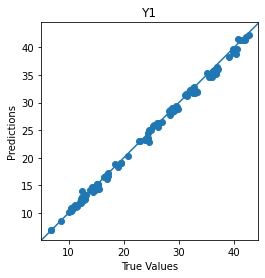

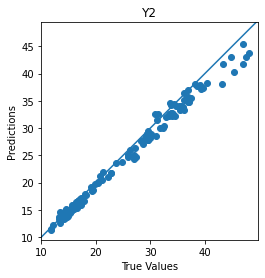

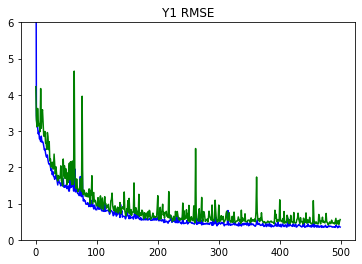

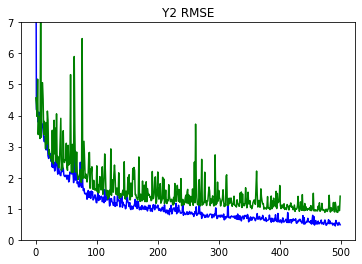

In [9]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)